# Лабараторная работа №1

Выполнила Рындина Валерия, M33351

In [34]:
# %pip install geopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import *
import scipy.interpolate as sc

plt.rcParams['figure.figsize'] = (12, 7)

## 1. Предобработка

Использованные данные: Data Science for COVID-19 - информация о распространении коронавируса в Южной Корее в 2020 году

In [35]:
dt_cases = pd.read_csv('data/raw/Case.csv')

### 1. Обработайте недостающие данные в датасете - удалить/заменить/etc, обоснуйте своё решение

* В данных пропущены города и соответственно их координаты. Заменим отсутствующие города на `from other city`, а координаты на среднее координат соседних строк.
* Также в `infection_case` несколько раз написано `etc`. Заменим это на значение в предыдущей строчке.

In [36]:
dt_cases.city.loc[dt_cases.city == '-'] = "from other city"

def fill_coordinate(s: pd.Series):
    s.loc[s.eq("-")] = np.nan
    # s.interpolate(method='polynomial')
    s.ffill(inplace=True)

fill_coordinate(dt_cases.latitude)
fill_coordinate(dt_cases.longitude)

dt_cases.infection_case.loc[dt_cases.infection_case.eq("etc")] = np.nan
dt_cases.infection_case.ffill(inplace=True)

/home/valrun/Repositories/CT-19/5 sem/pythonProject/venv/lib/python3.8/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### 2. Постройте как минимум по 1 графику каждого типа из представленных на лекции. Для каждого построенного графика объясните почему отображённые данные лучше всего представимы именно этим типом графика

#### Простой график

* Построим график количества подтвержденных случаев заболевания в каждом деле.
* Заметим, что есть одно значение свыше 4000, из-за которого не наглядно представлены данные. Построим график с ограничением.
* Теперь по графику можно сказать, что только единичные случая, когда подтверждено сразу более 100 случаев. В основном это значение менее 50.

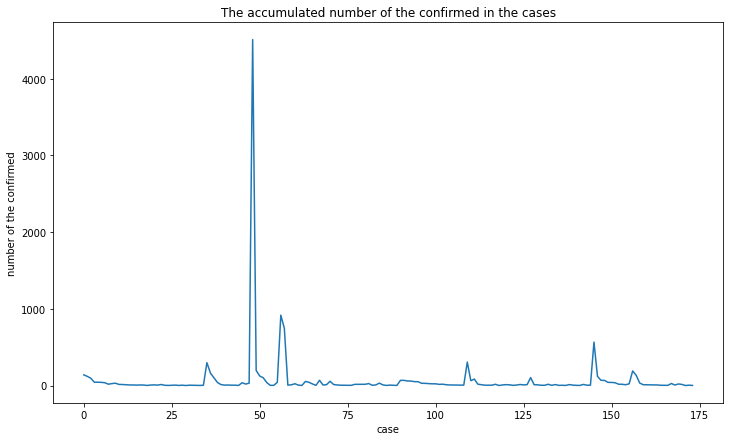

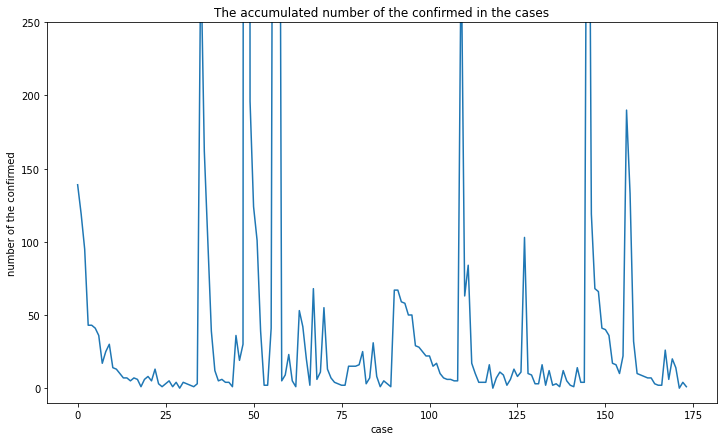

In [37]:
def get_confirmed_plot():
    plt.plot(dt_cases.confirmed)
    plt.title('The accumulated number of the confirmed in the cases')
    plt.xlabel("case")
    plt.ylabel("number of the confirmed")

get_confirmed_plot()
plt.show()

get_confirmed_plot()
plt.ylim(-10, 250)
plt.show()

#### Гистограмма

* Теперь посмотри распределение данных по провинциям. Используем горизонтальную гистограмму, чтобы прочитать названия провинций и посмотреть сколько случаев в каждой

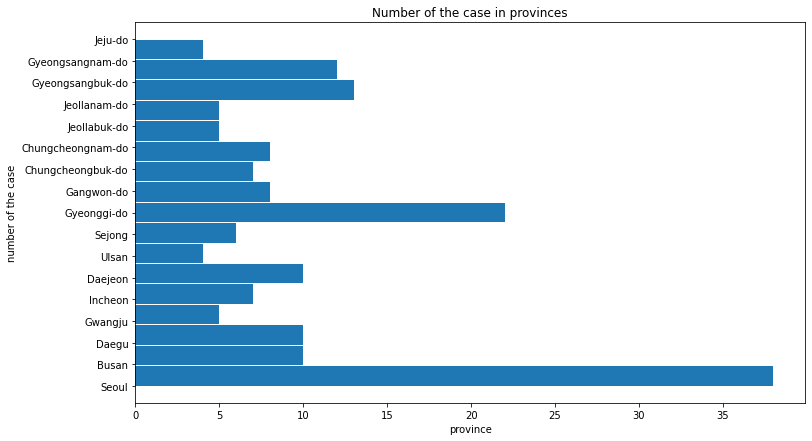

In [38]:
plt.hist(dt_cases.province,
         bins=dt_cases.province.nunique(),
         rwidth=0.95,
         orientation='horizontal')

plt.title('Number of the case in provinces')
plt.xlabel("province")
plt.ylabel("number of the case")

plt.show()

#### 2d гистограмма

 * Построим 2d гистограмму по координатам и количеству случаев. Данный график напоминает карту и показывает самые "опасные" зоны для заражения

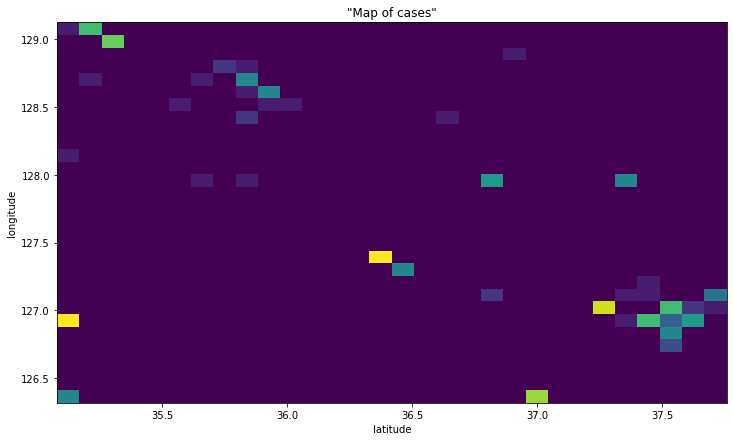

In [39]:
latitude = np.array(dt_cases.latitude, dtype=float)
longitude = np.array(dt_cases.longitude, dtype=float)

plt.title('"Map of cases"')
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.hist2d(latitude, longitude, bins=30)

plt.show()

#### Рассеяния
* С помощью этого графика мы можем увидеть, как много городов имеет подтвержденные случаи в каждой провинции

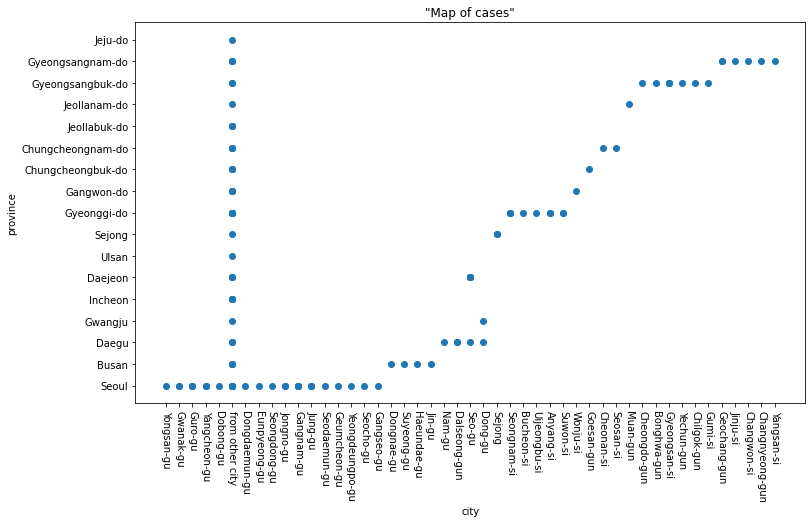

In [40]:
sub_dt_cases = dt_cases.loc[dt_cases.group.eq(True)]

plt.title('"Map of cases"')
plt.xlabel("city")
plt.xticks(rotation=270)
plt.ylabel("province")
plt.scatter(sub_dt_cases.city, sub_dt_cases.province)

plt.show()

#### Boxplots
* Для каждой провинции мы можем наглядно увидеть статистику

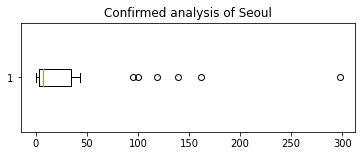

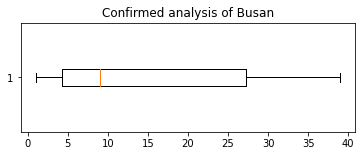

In [41]:
def show_boxplot_province(province_name) :
    province = dt_cases.loc[dt_cases.province.eq(province_name)]
    plt.boxplot(province.confirmed,
                vert=False)
    plt.title('Confirmed analysis of ' + province_name)
    plt.show()

plt.rcParams['figure.figsize'] = (6, 2)

provinces = dt_cases.province.unique().take(np.arange(2))
for p in provinces :
    show_boxplot_province(p)

### 3. Сохраните датасет

In [42]:
dt_cases.to_csv('data/Cases.csv')

### 4. Создайте новую колонку, отображающую характеристику набора данных. Новая колонка должна обладать смысловой нагрузкой.

In [43]:
from statistics import mode, median
from geopy.distance import distance

mode_lat = (2 * median(map(float,dt_cases.latitude)) + mode(map(float,dt_cases.latitude))) / 3
mode_lon = (2 * median(map(float,dt_cases.longitude)) + mode(map(float,dt_cases.longitude))) / 3
mode_point = (mode_lat, mode_lon)

distance_array = []
for i in range(dt_cases.latitude.size):
    lat = float(dt_cases.latitude[i])
    lon = float(dt_cases.longitude[i])
    point = (lat, lon)
    distance_array.append(distance(mode_point, point).km)

dt_cases_with_distance = dt_cases.assign(distance=distance_array)
dt_cases_with_distance.to_csv('data/CasesWithDistance.csv')

## 2. Интерполяция кривой

### Сгенерируйте от 5 до 20 точек со случайными разными координатами (x, y), расположите их на координатной плоскости

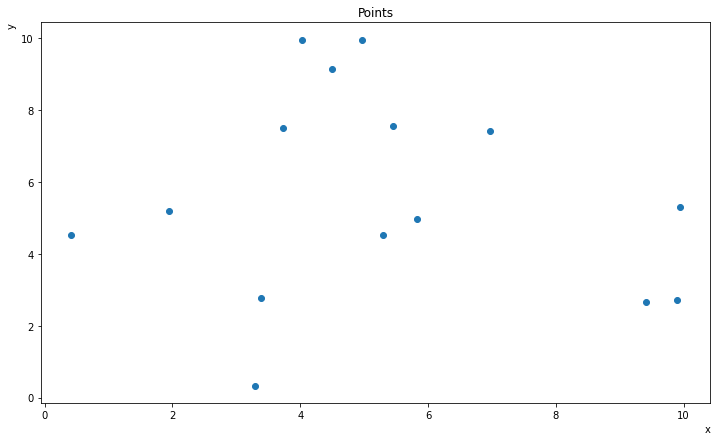

In [44]:
count = randint(5, 20)
pointX = np.random.rand(count) * 10
pointX.sort()
pointY = np.random.rand(count) * 10

plt.rcParams['figure.figsize'] = (12, 7)
plt.title("Points")
plt.xlabel("x", loc = "right")
plt.ylabel("y", loc = "top")
plt.scatter(pointX, pointY)
plt.show()

### 1. С помощью библиотеки scipy примените один из её алгоритмов интерполяции к сгенерированным данным

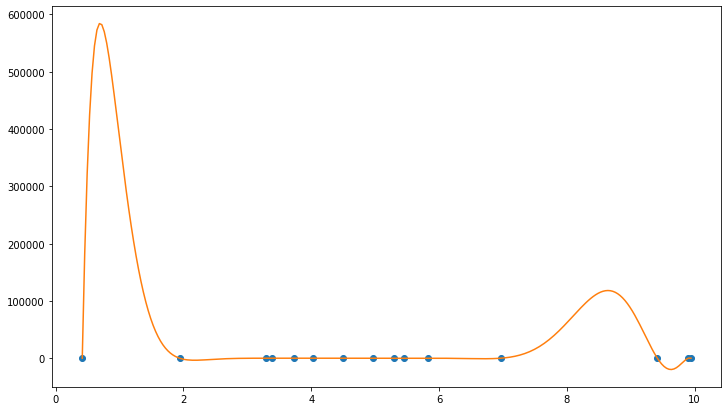

In [45]:
f = sc.lagrange(pointX, pointY)
lines = np.linspace(min(pointX), max(pointX), num=250)

plt.plot(pointX, pointY, 'o', lines, f(lines))
plt.show()

### 2. Изучите математический подход метод выбранного алгоритма интерполяции в scipy. Найдите и продемонстрируйте при сдаче реализацию метода в исходном коде библиотеки scipy.
 * продемонстрируем `lagrange()`
 * $$ l_i(x)=\prod_{j=0, j\neq i}^{n} \frac{x-x_j}{x_i-x_j} = \frac{x-x_0}{x_i-x_0} \cdots \frac{x-x_{i-1}}{x_i-x_{i-1}} \cdot \frac{x-x_{i+1}}{x_i-x_{i+1}} \cdots \frac{x-x_{n}}{x_i-x_{n}} $$

In [46]:
# def lagrange(x, w):
#     M = len(x)
#     p = poly1d(0.0)
#     for j in range(M):
#         pt = poly1d(w[j])
#         for k in range(M):
#             if k == j:
#                 continue
#             fac = x[j]-x[k]
#             pt *= poly1d([1.0, -x[k]])/fac
#         p += pt
#     return p

### 3. Выберите среди методов интерполяции в scipy любой другой метод интерполяции (кроме линейной интерполяций). Реализуйте выбранный метод без использования сторонних библиотек. Разрешается использовать numpy для упрощения математичеких вычислений

In [47]:
def my_next_interpolate (points_x, points_y) :
    # exception if points_x - not sorted
    def check(x) :
        return points_y[np.searchsorted(points_x, x)]

    def fun(xs) :
        res = []
        for x in xs:
            res.append(check(x))
        return res
    return fun

### 4. Визуализируйте кривую интерполяции библиотечного и вашего алгоритмов с помощью  matplotlib. Сравните качество интерполяции своего и библиотечного методов, объясните разницу в качестве
* метод понят и реализован правильно

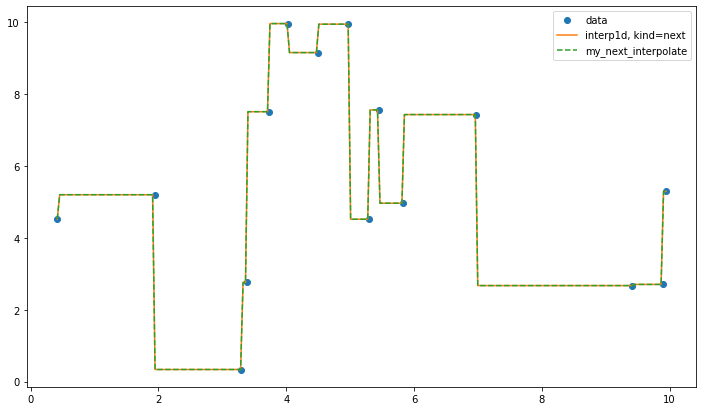

In [48]:
f = sc.interp1d(pointX, pointY, kind='next')
my_f = my_next_interpolate(pointX, pointY)

plt.plot(pointX, pointY, 'o', lines, f(lines), '-', lines, my_f(lines), '--')
plt.legend(['data', 'interp1d, kind=next', 'my_next_interpolate','nearest'], loc = 'best')
plt.show()

## 3. Быстрая гистограмма

Иногда хочется получить дискретное распределение из N колонок. Но пока что для этого у нас есть только plt.hist(), которая тратит много времени на отрисовку графика. Вам предлагается реализовать свою функцию построения дискретного распределения

### 1. Алгоритм должен получать на вход список чисел и количество колонок гистограммы. Возвращать нужно значения столбцов (ось абсцисс гистограммы) и количество значений, принадлежащее столбцу (ось ординат гистограммы). Пример с использованием plt показан ниже, сигнатура функции также показана ниже

In [49]:
from typing import List, Tuple, Union

def fast_hist(array: List[Union[int, float]],
              bins: int) -> Tuple[List[int], List[float]]:
    """
    Builds bins' labels and bins' value counts for given array
    :param array: array with numeric values
    :param bins:  number of bins in result distribution
    :return: Two lists:
             first contains value counts of each bin,
             second contains list of bins' labels
    """

    min_array = min(array)
    max_array = max(array)
    step = (max_array - min_array)/bins

    res = np.zeros_like(np.ones(bins, dtype= int))
    for el in array :
        index = int((el - min_array) / step) if el < max_array else bins - 1
        res[index] += 1

    return list(res), list(np.arange(min_array, max_array, step))

### 2. Изучите функцию plt.bar. Это такая же гистограмма как plt.hist, но в отличие от hist требуется явно указывать высоту колонок и их название
### 3. С помощью результатов своего алгоритма и plt.bar постройте гистограмму по массиву из 50+ случайных чисел. Графики plt.bar по вашему алгоритму и plt.hist() должны совпадать, что подтвердит корректность работы вашего алгоритма
* графики простроенные `hist` и `fast_hist` совпадвют

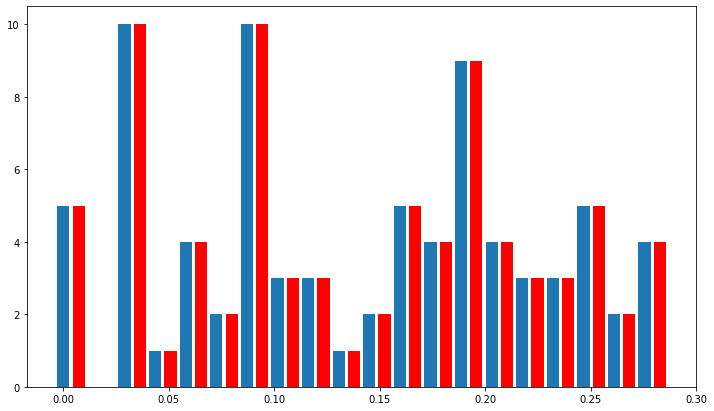

In [50]:
random_array = np.random.randint(30, size=80) / 100
bins = 20

value_counts, bins_names = fast_hist(random_array, bins)
width = (bins_names[1]-bins_names[0]) * 0.4
plt.bar(bins_names, value_counts, width=width)
plt.hist(random_array, bins=bins,
         rwidth=0.4,
         facecolor='r')
plt.show()

### 4. Сравните скорость построения распределения по массиву чисел с помощью своего алгоритма и с помощью plt.hist. В jupyter рекомендуется использовать built-in magic commands, а именно timeit. Но можно обойтись и ручными измерениями времени выполнения
* `hist` медленнее `fast_hist`, как и следовало ожидать

65.9 µs ± 31.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
8.42 ms ± 555 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


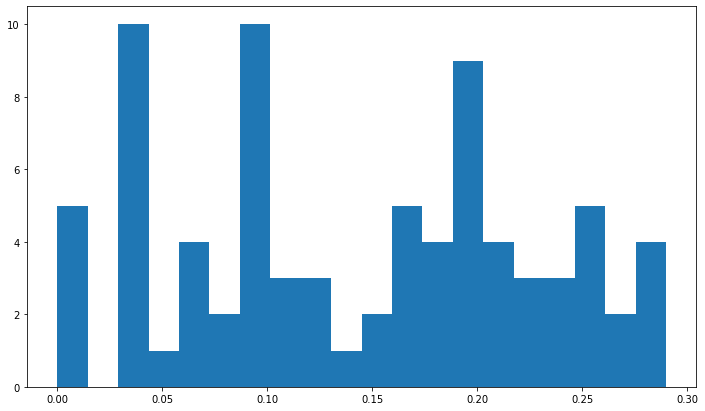

In [51]:
%timeit fast_hist(random_array, bins)
%timeit plt.hist(random_array, bins)
